In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, shapiro
from lib.functions import eda_stats, daily_returns_dist_and_ts
# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import plotting
from datetime import datetime
from dateutil import relativedelta

### <span style="color:red">obudować wszystko w funkcje i wrzucić do functions.py zrobić czysty notebook gdzie używane są tylko moje funkcje do każdego kroku</span>



### Loading Data

In [2]:
stocks = ["VWRA.L", "VDTY.L"]

In [3]:
prices = yf.download(stocks, start = "2020-01-01", end = "2024-01-01")['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [4]:
prices.columns = ['bonds', 'stocks']

In [5]:
prices.head(2)

,bonds,stocks
Date,,
2020-01-02,22.580709,86.695
2020-01-03,22.677057,86.375


In [6]:
prices.to_pickle('prices.pkl')

### Exploratory Data Analysis

In [40]:
prices = pd.read_pickle('prices.pkl')

In [8]:
# Calculating daily returns
returns = prices.pct_change().dropna()
returns.head(2)

,bonds,stocks
Date,,
2020-01-03,0.004267,-0.003691
2020-01-06,-0.000774,-0.001968


In [9]:
eda_stats(returns['stocks'])

Average annualized return: 0.10216630457053855
Annualized volatility (std): 0.19554451401989245
Skewness: -0.4910793675267943
Excess kurtosis: 8.10850567603738

Shapiro-Wilk test for normality
Null hypothesis of normality is rejected.


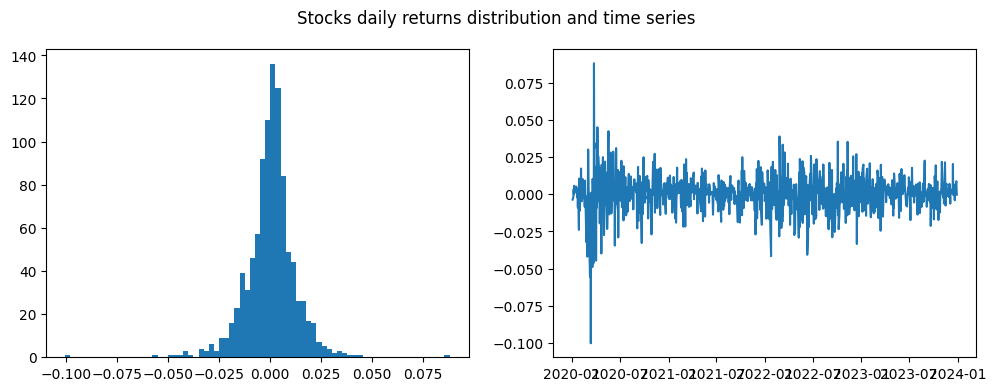

In [10]:
daily_returns_dist_and_ts(returns['stocks'])

In [11]:
eda_stats(returns['bonds'])

Average annualized return: -0.009470113309192008
Annualized volatility (std): 0.059274185033531226
Skewness: 0.4437360634536013
Excess kurtosis: 3.030786224271168

Shapiro-Wilk test for normality
Null hypothesis of normality is rejected.


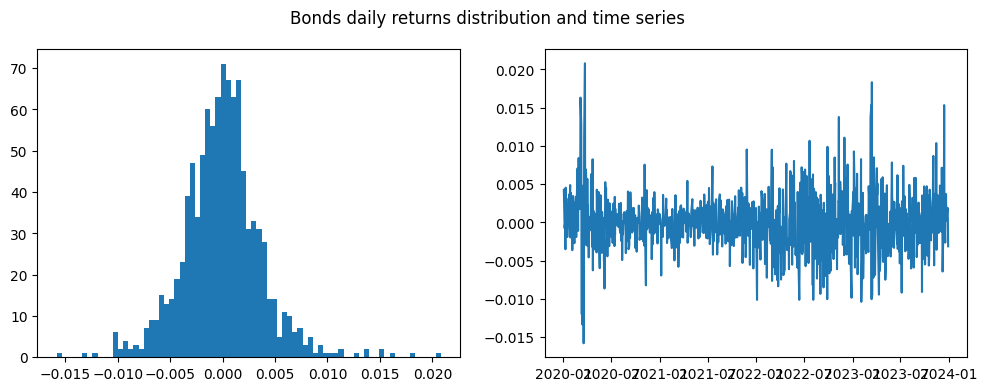

In [12]:
daily_returns_dist_and_ts(returns['bonds'])

### Calculating Portfolio

In [13]:
# Adding equal weighted portfolio
weights = np.array([0.50, 0.50])
returns['portfolio_ew'] = returns.dot(weights)
returns.head(2)

,bonds,stocks,portfolio_ew
Date,,,
2020-01-03,0.004267,-0.003691,0.000288
2020-01-06,-0.000774,-0.001968,-0.001371


<Axes: xlabel='Date'>

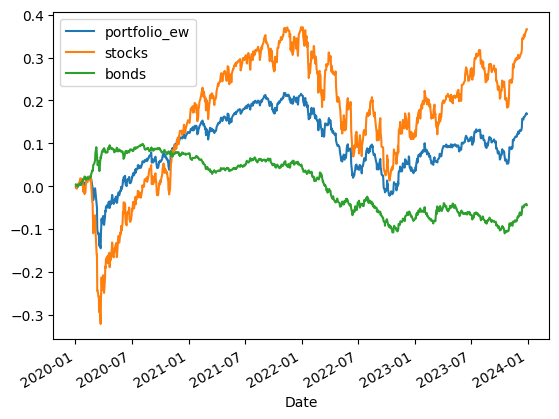

In [50]:
# Ploting cumulative returns of assets and the portfolio
cum_returns = ((1+returns[['portfolio_ew','stocks','bonds']]).cumprod()-1)
cum_returns.plot()

### Drawdown

In [41]:
weights = np.array([0.50, 0.50])
prices['portfolio_ew'] = prices.dot(weights)
pf_price = prices['portfolio_ew']
pf_price.head(2)

Date
2020-01-02    54.637855
2020-01-03    54.526029
Name: portfolio_ew, dtype: float64

In [48]:
# Sortino ratio - similar to sharpe ratio, just with a diferent std, downside risk

rfr = 0
target_return = 0

pf_returns = pd.DataFrame(pf_price.pct_change())

negative_returns = pf_returns.loc[pf_returns['portfolio_ew'] < target_return]

expected_return = pf_returns['portfolio_ew'].mean()

down_stdev = negative_returns.std()

sortino_ratio = (expected_return - rfr) / down_stdev
print(sortino_ratio)

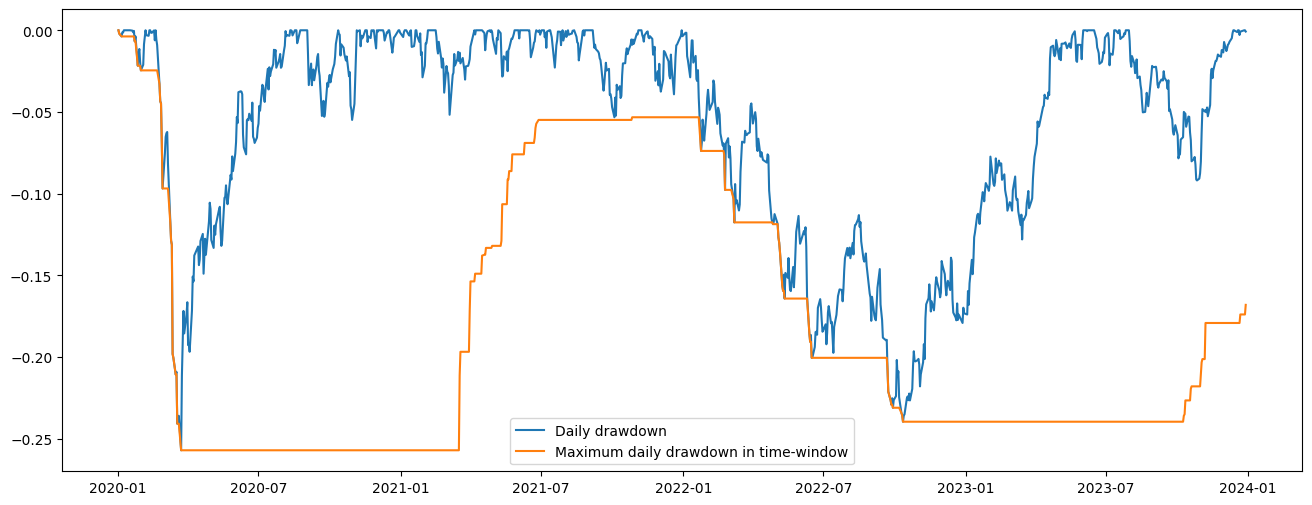

In [51]:
# Maximum draw-down - the target pct loss from a market peak to trough, depend on time window
# maximum daily draw-down
# max of returns
roll_max = pf_price.rolling(min_periods=1, window=250).max()
# daily draw-down
daily_drawdown = pf_price/roll_max - 1.0
# max daily draw-down
max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=250).min()
# plot
date = daily_drawdown.index
plt.figure(figsize=(16,6))
plt.plot(date, daily_drawdown, label='Daily drawdown')
plt.plot(date, max_daily_drawdown, label='Maximum daily drawdown in time-window')
# daily_drawdown.rename('Daily drawdown').plot()
# max_daily_drawdown.rename('Maximum daily drawdown in time-window').plot()
plt.legend()
plt.show()

### Efficient Frontier

In [15]:
numstocks=2

In [16]:
correlation_matrix = returns.iloc[:,0:numstocks].corr()

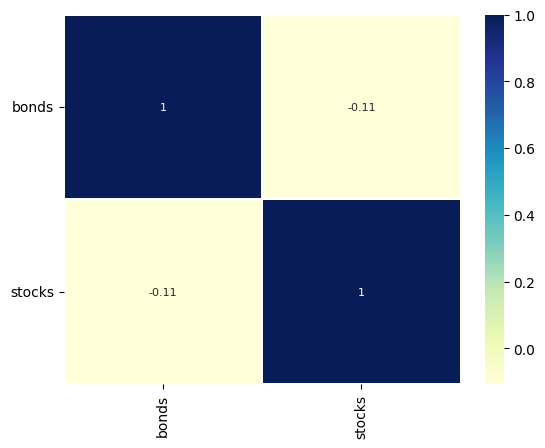

In [17]:
 # Import seaborn as sns
import seaborn as sns

# Create a heatmap
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})

# Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

In [18]:
# Calculate the covariance matrix
cov_mat = returns.iloc[:,0:numstocks].cov()
# Annualize the co-variance matrix
cov_mat_annual = cov_mat*252
# Print the annualized co-variance matrix
print(cov_mat_annual)

           bonds    stocks
bonds   0.003517 -0.001247
stocks -0.001247  0.038276


In [19]:
# Calculate the portfolio standard deviation (volatility)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat_annual, weights)))
print(portfolio_volatility)

0.09911864369524341


In [20]:
df = returns.iloc[:,0:numstocks]

bonds    -0.009515
stocks    0.097296
dtype: float64

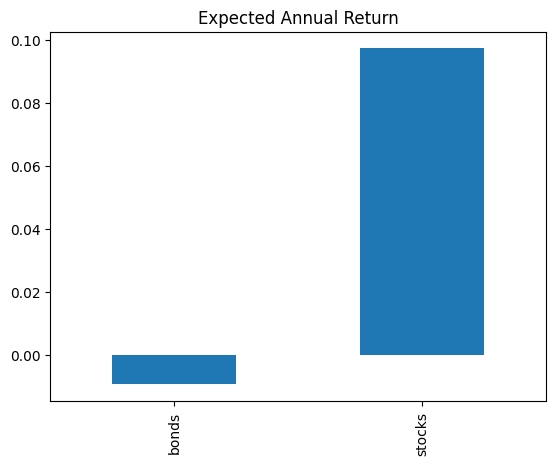

In [21]:
# get average daily return times 365.25 in the year that is extracted from dataset
e_r = df.mean()*252

# plot exp return
e_r.plot(kind='bar')
plt.title('Expected Annual Return');

e_r

In [22]:
cov_matrix = df.cov()

In [23]:
p_ret = []
p_weights = []
p_vol = []
risk_free = 0

# set no. of assets and portfolios to simulate
num_assets = len(df.columns)
num_portfolios = 10000

# for each random portfolio, find the return and volatility
for portfolio in range(num_portfolios):
    # create random weights
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    ret = np.dot(weights,e_r)
    p_ret.append(ret)
    
    var = cov_matrix.mul(weights,axis=0).mul(weights,axis=1).sum().sum()
    ann_sd = np.sqrt(var*365.25)
    p_vol.append(ann_sd)
    
data = {'returns': p_ret, 'volatility': p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol + '_weight'] = [w[counter] for w in p_weights]
    
portfolios = pd.DataFrame(data)
portfolios['sharpe'] = (portfolios['returns'] - risk_free) / portfolios['volatility']
portfolios = portfolios[list(df.columns + '_weight') + ['returns', 'volatility', 'sharpe']]

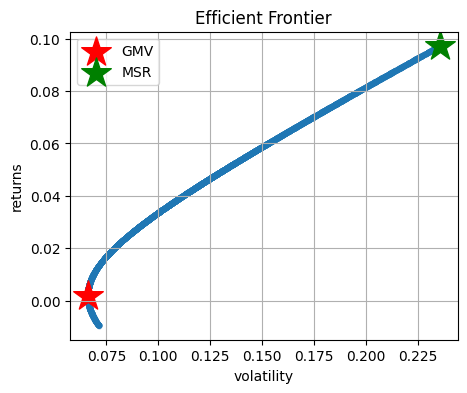

In [24]:
# portfolios with lowest volatility
min_var_port = portfolios.loc[portfolios['volatility'].idxmin()]
max_shp_port = portfolios.loc[portfolios['sharpe'].idxmax()]

portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[5,4])
plt.scatter(x=min_var_port[3],y=min_var_port[2],\
            color='r', marker='*', s=500, label='GMV')
plt.scatter(x=max_shp_port[3],y=max_shp_port[2],\
            color='g', marker='*', s=500, label='MSR')
plt.legend()
plt.title('Efficient Frontier');

In [25]:
# dodać możliwość znalezienia optymalnego portfela dla zadanego VOLATILITY i RETURN
# czyli chyba po prostu max sharpe z warunkiem na vol <=

In [54]:
# Sort the portfolios by Sharpe ratio
sorted_portfolios = portfolios[portfolios['volatility'] <= 0.15].sort_values(by=['sharpe'], ascending=False)

# Extract the corresponding weights
portfolio_weights = sorted_portfolios.iloc[0, 0:numstocks]

In [55]:
portfolio_weights

bonds_weight     0.360888
stocks_weight    0.639112
Name: 3484, dtype: float64

### Markowitz portfolios

In [28]:
portfolios.head(3)

,bonds_weight,stocks_weight,returns,volatility,sharpe
0,0.364594,0.635406,0.058354,0.149125,0.391306
1,0.481177,0.518823,0.045901,0.123332,0.372176
2,0.140269,0.859731,0.082314,0.201666,0.408169


In [29]:
# Print the range of Sharpe ratios
print(portfolios['sharpe'].describe()[['min', 'max']])

min   -0.133234
max    0.413081
Name: sharpe, dtype: float64


In [30]:
# Sort the portfolios by Sharpe ratio
sorted_portfolios = portfolios.sort_values(by=['sharpe'], ascending=False)

# Extract the corresponding weights
MSR_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the MSR weights as a numpy array
MSR_weights_array = np.array(MSR_weights)

<Axes: xlabel='Date'>

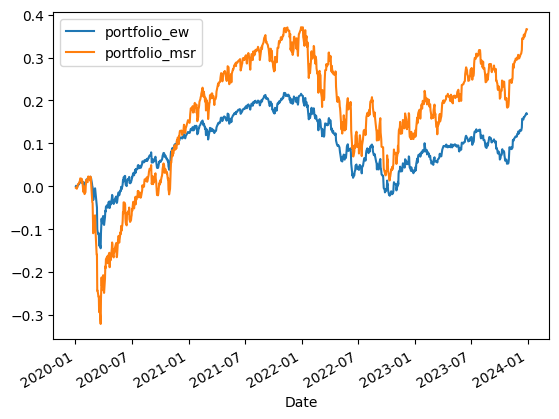

In [31]:
# Calculate the MSR portfolio returns
returns['portfolio_msr'] = returns.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

# Plot the cumulative returns
CumulativeReturns = ((1 + returns).cumprod() - 1)
CumulativeReturns[['portfolio_ew', 'portfolio_msr']].plot()

<Axes: xlabel='Date'>

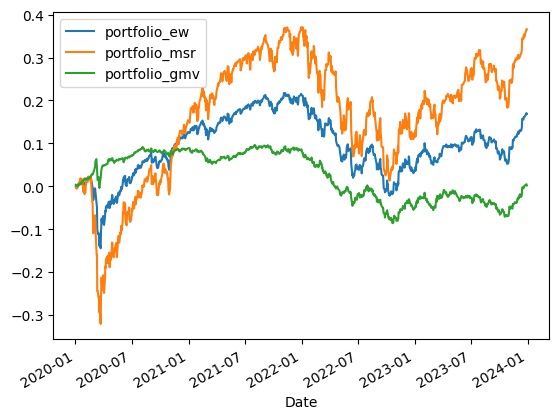

In [32]:
# Sort the portfolios by volatility
sorted_portfolios = portfolios.sort_values(by=['volatility'], ascending=True)

# Extract the corresponding weights
GMV_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the GMV weights as a numpy array
GMV_weights_array = np.array(GMV_weights)

# Calculate the GMV portfolio returns
returns['portfolio_gmv'] = returns.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

# Plot the cumulative returns
Cumulativereturns = ((1 + returns).cumprod() -1)
Cumulativereturns[['portfolio_ew', 'portfolio_msr', 'portfolio_gmv']].plot()

In [33]:
# Find portfolio with Maximum Sharpe Ratio
MSR_weights

bonds_weight     0.00019
stocks_weight    0.99981
Name: 2000, dtype: float64

In [34]:
# Find portfolio with Global Minimum volatility
GMV_weights

bonds_weight     0.892368
stocks_weight    0.107632
Name: 5271, dtype: float64